In [1]:
import os
import gzip
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from nltk import word_tokenize
import matplotlib.pyplot as plt

from tools.utils import *



In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sent2vec.vectorizer import Vectorizer

Download the embeddings from here:

https://github.com/commonsense/conceptnet-numberbatch

In [3]:
filename = 'data/numberbatch-en-19.08.txt.gz'

In [4]:
i = 0
temp = {}

with gzip.open(filename, 'rb') as f:
    info = f.readlines(1)
    lines, dim = (int(x) for x in info[0].decode('utf-8').strip("\n").split(" "))
    
    for line in tqdm(f, total=lines):
        l = line.decode('utf-8')
        l_split = l.strip("\n").split(" ")

        word = l_split[0]
        arr = np.fromstring((" ").join(l_split[1:]), dtype=float, sep=" ")
        temp[word] = arr

In [10]:
# path to okvqa dataset (from text-investigation)
filename = 'OKVQA_object.json'
data_path = Path(os.getcwd()) / 'data'

okvqa = {}
okvqa['full'] = pd.read_json(data_path/filename)

In [41]:
question_embeddings = np.zeros((okvqa['full'].__len__(), 300))

for i, q_tokens in enumerate(tqdm(okvqa['full'].question_tokens)):
    q_embedding = []
    for token in q_tokens:
        try:
            arr = temp[token]
            q_embedding.append(arr)
        except KeyError:
            pass

    q_embedding = np.mean(q_embedding, axis=0)
    question_embeddings[i, :] = q_embedding


In [42]:
X_numberbatch = question_embeddings
X_numberbatch = StandardScaler().fit_transform(X_numberbatch)

In [43]:
X_numberbatch.shape

(14055, 300)

In [52]:
n_components = 10

# create principle component analysis
pca_numberbatch = PCA(n_components=n_components)
PC_numberbatch = pca_numberbatch.fit_transform(X_numberbatch)

# collect in dataframe
df_numberbatch = pd.DataFrame(data = PC_numberbatch, columns = [f'PC{i+1}' for i in range(n_components)])
df_numberbatch

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-5.295813,-6.804140,2.655548,3.112456,1.616068,-1.374471,2.819205,-1.225994,-0.004334,-0.863739
1,7.325495,7.166233,-5.597411,0.742575,5.273691,5.165277,2.313065,3.237750,-0.161148,-0.710615
2,-0.590590,0.322335,-2.780735,3.848056,1.613535,3.643410,0.645944,3.940366,1.577380,-2.105371
3,-1.139473,-5.156541,-6.790441,-2.307397,-4.506073,-0.802824,-0.489265,-1.416384,1.067493,0.933394
4,-0.142185,-1.211660,-7.771933,-2.273205,0.044420,-4.967569,-1.752765,3.720971,3.051658,0.677696
...,...,...,...,...,...,...,...,...,...,...
14050,0.412091,-4.979974,0.393656,-1.124579,-0.843401,-0.703610,-0.677504,-0.379379,2.549754,1.458579
14051,-6.197286,-3.069509,-0.866596,-1.406520,-0.320642,-1.542629,1.183989,-0.536702,-0.197103,-0.177393
14052,1.627983,1.481853,-3.479059,-0.233430,4.075471,7.504248,-1.553637,2.607135,-2.709409,-0.370921
14053,1.980953,4.486422,-1.444906,-3.040142,3.209930,1.321782,5.126690,0.208739,-1.704872,-2.134424


In [33]:
# initialize parameters
vectorizer = Vectorizer()

# vectorize questions
for question in tqdm(okvqa['full'].question_str):
    question = [question]

    # vectorize the questions
    vectorizer.run(question)
    vectors = vectorizer.vectors

# get dataframe
X_sent2vec = np.array(vectors)

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# standardize data
X_sent2vec = StandardScaler().fit_transform(X_sent2vec)

assert np.allclose(X_sent2vec.mean(axis=0), 0, atol=1e-5)
assert np.allclose(X_sent2vec.std(axis=0), 1, atol=1e-5)

In [53]:
n_components = 10

# create principle component analysis
pca_sent2vec = PCA(n_components=n_components)
PC_sent2vec = pca_sent2vec.fit_transform(X_sent2vec)

# collect in dataframe
df_sent2vec = pd.DataFrame(data = PC_sent2vec, columns = [f'PC{i+1}' for i in range(n_components)])
df_sent2vec

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.584144,-5.527435,7.766850,-2.475657,1.793561,6.935283,3.693066,-1.231720,-4.149267,0.536866
1,-2.993804,-0.145999,1.199739,0.777462,-2.889917,-5.257545,8.011762,6.531038,7.315579,3.704987
2,-3.356619,-9.367630,4.061337,2.838860,-3.526069,1.078825,3.919549,-2.605757,9.781079,6.889769
3,8.603480,-2.751825,-2.777482,0.839208,4.319466,-8.949938,6.596238,3.255855,3.324933,3.949052
4,3.835238,2.917155,-0.096681,8.095821,-3.913945,20.627468,2.578539,1.792085,2.823074,10.915939
...,...,...,...,...,...,...,...,...,...,...
14050,-2.597596,-2.332424,0.830540,1.263718,-3.197880,0.886783,5.225182,0.357455,-3.236986,4.684680
14051,4.476380,-7.622294,6.509977,-3.182165,-1.942247,2.946769,5.640180,-3.065332,-4.134336,-0.637639
14052,-8.279050,0.987396,4.066278,-1.321740,4.299529,-2.524981,0.100992,6.203453,11.270393,6.563725
14053,5.930909,-5.273306,8.155542,-0.527722,-5.489860,-9.905209,-3.293505,-3.817788,9.978897,-0.847794


In [56]:
q_type = {'eight': 'Plants and Animals',
         'nine': 'Science and Technology',
         'four': 'Sports and Recreation',
         'six': 'Geography, History, Language and Culture',
         'two': 'Brands, Companies and Products',
         'other': 'Other',
         'one': 'Vehicles and Transportation',
         'five': 'Cooking and Food',
         'ten': 'Weather and Climate',
         'seven': 'People and Everyday life',
         'three': 'Objects, Material and Clothing'}

In [58]:
df_numberbatch['question_type'] = okvqa['full']['question_type'].map(q_type)
df_sent2vec['question_type'] = okvqa['full']['question_type'].map(q_type)

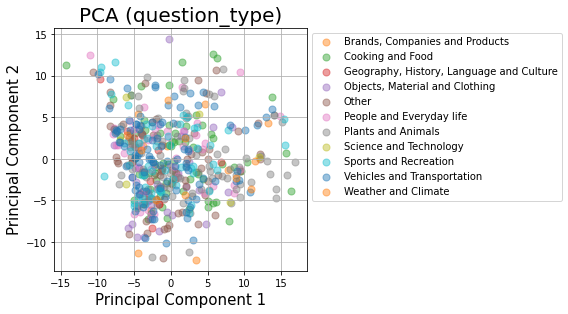

In [73]:
fig = plt.figure(figsize=(8,8))

ax, targets = plot_PCA(fig, df_numberbatch.sample(500, random_state=42), 'question_type', subplot=211, chosen_PCs=(1,2))
ax.legend(targets, bbox_to_anchor=(1, 1))
plt.tight_layout()

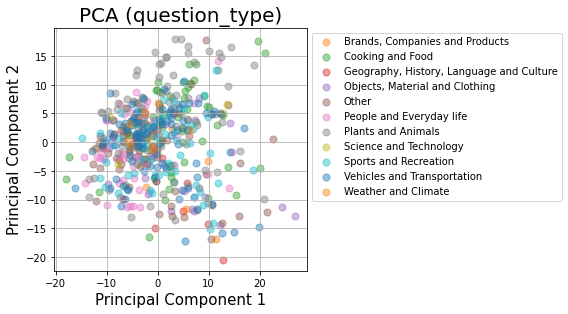

In [70]:
fig = plt.figure(figsize=(8,8))

ax, targets = plot_PCA(fig, df_sent2vec.sample(500, random_state=42), 'question_type', subplot=211, chosen_PCs=(1,2))
ax.legend(targets, bbox_to_anchor=(1, 1))
plt.tight_layout()

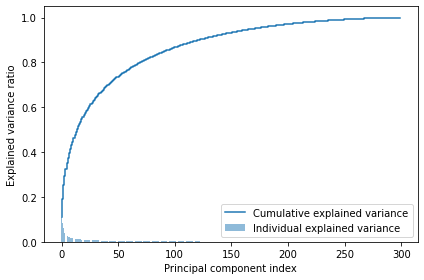

-----------------------------------
Accumulated explained variance:
-----------------------------------
PC1) 10.98%
PC2) 19.19%
PC3) 25.19%
PC4) 29.14%
PC5) 32.56%
PC6) 35.22%
PC7) 37.52%
PC8) 39.54%
PC9) 41.39%
PC10) 43.10%


In [74]:
n_components = 10

# create principle component analysis
pca = PCA()
PC = pca.fit_transform(X_numberbatch)
exp_var_pca = pca.explained_variance_ratio_

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca.cumsum())), exp_var_pca.cumsum(), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"{'-'*35}\nAccumulated explained variance:\n{'-'*35}")
for i, explained_var in enumerate(exp_var_pca.cumsum()[:n_components]):
    print(f"PC{i+1}) {explained_var*100:.2f}%")

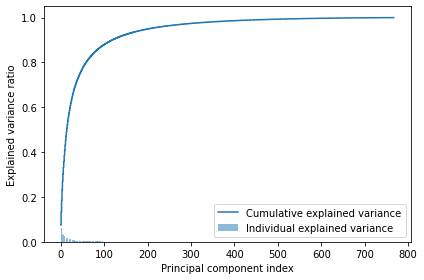

-----------------------------------
Accumulated explained variance:
-----------------------------------
PC1) 7.48%
PC2) 13.43%
PC3) 18.45%
PC4) 23.31%
PC5) 26.88%
PC6) 30.24%
PC7) 33.20%
PC8) 35.81%
PC9) 38.38%
PC10) 40.77%


In [75]:
n_components = 10

# create principle component analysis
pca = PCA()
PC = pca.fit_transform(X_sent2vec)
exp_var_pca = pca.explained_variance_ratio_

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca.cumsum())), exp_var_pca.cumsum(), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"{'-'*35}\nAccumulated explained variance:\n{'-'*35}")
for i, explained_var in enumerate(exp_var_pca.cumsum()[:n_components]):
    print(f"PC{i+1}) {explained_var*100:.2f}%")